In [1]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'
#rcParams['mathtext.fontset'] = 'custom'
#rcParams['mathtext.rm'] = 'Arial'


import pandas as pd
import numpy as np
import ipympl
import matplotlib.pyplot as plt

import seaborn as sbn
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_venn import venn2
#import plotly.plotly as py
#import plotly.graph_objs as go
from scipy.interpolate import griddata
from matplotlib import cm
from matplotlib import gridspec

% matplotlib inline
sbn.set(style='white', font_scale=1.5,
       rc={"font.size":16, "axes.titlesize":14, 
           "axes.labelsize":14, "xtick.labelsize":14,
           "ytick.labelsize":14,})
            #"font.family":'serif', "font.serif":'Arial'})
sbn.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size":6})
import datetime
curdate = str(datetime.datetime.now()).split(' ')[0].replace("-", "")

# Use CPM as cleavage efficiency

In [2]:
#dfG = pd.read_csv('../processed_data/GUIDE_sup_data_RPM_clean.csv', index_col=0)
dfG = pd.read_csv('../processed_data/20181216_GUIDE_sup_data_RPM_clean.csv', index_col=0)
#dfC = pd.read_csv('../processed_data/CIRCLE_sup_data_RPM_clean.csv', index_col=0)
dfC = pd.read_csv('../processed_data/20181216_CIRCLE_sup_data_RPM_clean.csv', index_col=0)
dfC['chr'] = dfC['chr'].str.replace('chr', '')
dfG['chr'] = dfG['chr'].str.replace('chr', '')
# cpm: cleavage count per million mappable reads, CPM in manuscript
# sumcov: sum of DNase-Seq coverage within given window, Read count per Million mappable reads per basepair (RPM)
# CFD: Cutting Frequency Determination score, an estimated likelihood of gRNA:target binding/cleavage

## GUIDE-Seq / CIRCLE-Seq overlap 

In [3]:
def ran(row):
    return list(np.arange(row['bStart']-100, row['bEnd']+100))
def findoverlap(dfBase, dfCompare, identified, miss):
    dfTmp = dfBase.iloc[:, :3]
    x = dfTmp.apply(ran, axis=1).values
    xnp = np.array([np.array(xi) for xi in x])
    in_guide = []

    for idx, row in dfCompare.iterrows():
        pos_exist = np.logical_or(np.any(xnp==row['bStart'], axis=1), np.any(xnp==row['bEnd'], axis=1))
        chr_exist = np.array(dfBase['chr']== row['chr'])
        if np.logical_and(pos_exist, chr_exist).any():
            in_guide.append(identified)
        else:
            in_guide.append(miss)
    return in_guide

In [4]:
dfC['inguide'] = findoverlap(dfG, dfC, 1, 0)

In [5]:
dfC['inguide'].value_counts()

0    5189
1     398
Name: inguide, dtype: int64

In [6]:
dfG['inguide'] = findoverlap(dfC, dfG, 1, 2)

In [7]:
dfG['inguide'].value_counts()

1    400
2     20
Name: inguide, dtype: int64

In [62]:
dfG4.pivot_table(index='target_name', columns='inguide', aggfunc='size', fill_value=0).to_csv('../processed_data/20190501_GUIDESeq_intersect_table.csv')

In [63]:
dfF4.pivot_table(index='target_name', columns='inguide', aggfunc='size', fill_value=0).to_csv('../processed_data/20190501_CIRCLESeq_intersect_table.csv')

## Clip to the lowest value and log transformation

In [8]:
def scale(ser):
    s_min = ser.min()
    s_max = ser.max()
    ser = (ser-s_min) / (s_max-s_min)
    return ser

def clipcut(numar):
    return sorted(numar)[1]

In [9]:
def addCol(dfPro):

    dfPro['logCFD'] = dfPro['CFD'].clip_lower(clipcut(dfPro['CFD'].unique())).map(np.log10)
    dfPro['logCov'] = dfPro['normed_sumCov'].clip_lower(clipcut(dfPro['normed_sumCov'].unique())).map(np.log10)
    dfPro['logRead'] = dfPro['normed_read_count'].clip_lower(clipcut(dfPro['normed_read_count'].unique())).map(np.log10)
    dfPro['logKine'] = dfPro['Kinetic'].clip_lower(clipcut(dfPro['Kinetic'].unique())).map(np.log10)

    # Normalize log columns into 0-1 scale
    dfPro['normedLogCov'] = scale(dfPro['logCov'])
    dfPro['normedLogRead'] = scale(dfPro['logRead'])

    # Carry out a different normalization for # of hits identified by CIRCLE-Seq or GUIDE-Seq using total # of reads per gRNA
    dfPro['read_pergRNA'] = dfPro.groupby('gRNA_seq')['read_count'].transform(lambda x: x.sum())
    dfPro['read_pergRNA'] = dfPro['read_count'] / dfPro['read_pergRNA']
    dfPro['read_perg_log'] = np.log10(dfPro['read_pergRNA'])
    dfPro['normedReadPergLog'] = scale(dfPro['read_perg_log'])
    
    dfPro['logcpm'] = dfPro['cpm'].map(np.log10)
    return dfPro

In [10]:
# Add normed columns to dfFinal
dfC = addCol(dfC)
dfG = addCol(dfG)

## Subset of dfFinal for final analysis

In [11]:
dfF4 = dfC.copy() 
dfF4 = dfF4[~(dfF4['sumCov']==0)]
dfF4['inguide'].value_counts()

0    3783
1     354
Name: inguide, dtype: int64

In [12]:
dfG4 = dfG.copy() 
dfG4 = dfG4[~(dfG4['sumCov']==0)]
dfG4['inguide'].value_counts()

1    355
2     19
Name: inguide, dtype: int64

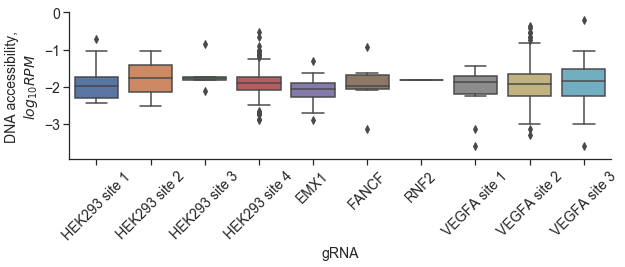

In [21]:
fig, ax = plt.subplots(1,1, figsize=(9,4))
#grouped = dfG4[dfG4['inguide']==1].groupby('target_name', axis=1)
#grouped.boxplot()
order = ['HEKgRNA1', 'HEKgRNA2', 'HEKgRNA3', 'HEKgRNA4', 'EMX1', 'FANCF', 'RNF2', 'VEGFA_site1', 'VEGFA_site2', 'VEGFA_site3']
sbn.boxplot(x='target_name', y='logCov', data=dfG4[dfG4['inguide']==1], ax=ax, order=order)
xlabels = ['HEK293 site 1','HEK293 site 2', 'HEK293 site 3', 'HEK293 site 4', 'EMX1', 'FANCF', 'RNF2', 'VEGFA site 1', 'VEGFA site 2', 'VEGFA site 3']
ax.set_xticklabels(xlabels, rotation=45)
ax.set_ylim(-3.95,0)
ax.set_ylabel('DNA accessibility,\n$log_{10}RPM$')
ax.set_xlabel('gRNA')
sbn.despine()
fig.tight_layout()
fig.savefig('../paper_figures/%s_GUIDESeq_gRNA_boxplot.png' % curdate, dpi=600)

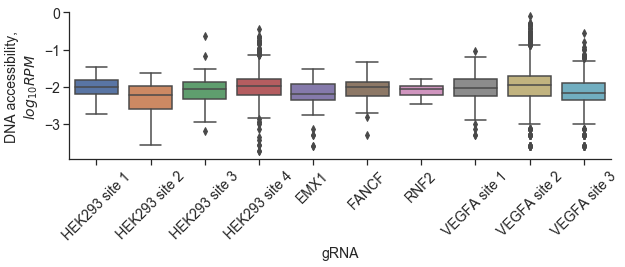

In [22]:
fig, ax = plt.subplots(1,1, figsize=(9,4))
#grouped = dfG4[dfG4['inguide']==1].groupby('target_name', axis=1)
#grouped.boxplot()
order = ['HEK293_Adli_site1', 'HEK293_Adli_site_2', 'HEK293_Adli_site_3', 'HEK293_combined_Adli_site_4', 'U2OS_exp2_EMX1', 'U2OS_exp2_FANCF', 'U2OS_exp2_RNF2', 'U2OS_exp2_VEGFA_site_1', 'U2OS_combined_VEGFA_site_2', 'U2OS_combined_VEGFA_site_3']
sbn.boxplot(x='target_name', y='logCov', data=dfF4[dfF4['inguide']==0], ax=ax, order=order)
xlabels = ['HEK293 site 1','HEK293 site 2', 'HEK293 site 3', 'HEK293 site 4', 'EMX1', 'FANCF', 'RNF2', 'VEGFA site 1', 'VEGFA site 2', 'VEGFA site 3']
ax.set_xticklabels(xlabels, rotation=45)
ax.set_ylim(-3.95,0)
ax.set_ylabel('DNA accessibility,\n$log_{10}RPM$')
ax.set_xlabel('gRNA')
sbn.despine()
fig.tight_layout()
fig.savefig('../paper_figures/%s_CIRCLESeq_gRNA_boxplot.png' % curdate, dpi=600)

In [13]:
def drawVenn(ax, df1, df2):
    venset = venn2(subsets= (df1['inguide'].value_counts()[2], 
                             df2['inguide'].value_counts()[0], 
                             df1['inguide'].value_counts()[1]), 
                             set_labels = ('A', 'B'), ax=ax)
    venset.get_patch_by_id('01').set_alpha(0.8)
    venset.get_patch_by_id('10').set_alpha(0.8)
    venset.get_patch_by_id('11').set_alpha(0.8)
    nums = venset.subset_labels
    
    for i, t in enumerate(nums):
        t.set_fontsize(12)
        if i==0:
            t.set_x(t.get_position()[0]-.05)
    labA = venset.get_label_by_id('A')
    labB = venset.get_label_by_id('B')
    labA.set_x(labA.get_position()[0] +.3)
    labA.set_y(labB.get_position()[1])
    labA.set_text('GUIDE-Seq\n(GS)')
    labA.set_fontsize(10)
    labB.set_text('CIRCLE-Seq\n(CS)')
    labB.set_fontsize(10)
    return ax

def f1(ax, df1, df2):
    a = df1.loc[df1['inguide']==1, 'logCov']
    b = df2.loc[df2['inguide']==0, 'logCov']
    am = a.mean()
    bm = b.mean()
    
    cur_statistic, cur_pvalue = stats.ttest_ind(a, b)
    #print(cur_statistic, cur_pvalue)
    #print(am, bm, (am-bm), 10**(am-bm))
    axbox = ax.boxplot([a,b], widths=0.6, 
                       showfliers=False)
    #for cap in axbox['caps']:
        #print(cap.get_ydata())
    g1x, g2x = ax.get_xticks()
    h1 = axbox['caps'][1].get_ydata()[0] +.2
    h2 = axbox['caps'][3].get_ydata()[0] +.2
    xdown, xup = ax.get_xlim()
    y = max(h1, h2) + (xup - xdown)*.1
    
    ax = addStats(ax, g1x, g2x, y, h1, h2, '*')
    ax.set_xticklabels(['GS and CS\n(N=%d)' % len(a), 
                        'CS only\n(N=%d)' % len(b)], {'size': 9})
    #print(ax.get_yticks())
    yticks = ax.get_yticks()
    ax.set_yticklabels(['%.1f' % i for i in yticks])
    ax.set_ylabel('DNA accessibility,\n$log_{10}RPM$')
    return ax

def f2(ax, df1, df2):
    a = df1.loc[df1['inguide']==1, 'normed_sumCov']
    b = df2.loc[df2['inguide']==0, 'normed_sumCov']
    am = a.mean()
    bm = b.mean()
    ax.bar(x=[0,1], height=[am/bm, bm/bm], fill=False, width=0.6, edgecolor=['black']*2, linewidth=1)
    ax.errorbar(x=[0,1], y=[am/bm, bm/bm], 
            yerr = [stats.sem(a)/am, stats.sem(b)/bm], linestyle=' ', 
            elinewidth=.8,
            capsize=6, capthick=1, color='k')
    ax.set_xticks(np.arange(0,2))
    ax.set_xlim(-.5, 1.5)
    ax.set_ylim(0,2.5)
    ax.hlines(y=1, xmin=-.5, xmax = 1.5, linestyle='--', color='gray', linewidth=1)
    g1x, g2x = ax.get_xticks()
    h1 = am/bm + stats.sem(a)/am +.1
    h2 = bm/bm + stats.sem(b)/bm +.1
    xdown, xup = ax.get_xlim()
    y = max(h1, h2) + (xup - xdown)*.1
    #print(h1, h2)
    ax = addStats(ax, g1x, g2x, y, h1, h2, '*')
    ax.set_xticklabels(['GS and CS\n(N=%d)' % len(a), 
                        'CS only\n(N=%d)' % len(b)], {'size': 9})
    ax.set_ylabel('DNA accessibility\n(Relatvie to CS only)')
    print(am, bm, am/bm)
    #print(stats.ttest_ind(a,b))
    return ax
    
def addStats(ax, g1x, g2x, y, h1, h2, smbl):
    ax.plot([g1x, g1x, g2x, g2x], [h1, y, y, h2], lw=0.8, c='k')
    ax.text((g1x+g2x)/2, y, smbl, ha='center', va='bottom', color='k')
    return ax

def poseFigord(ax):
    xmin, xmax = ax.get_xlim()
    #print(ax.get_xlim())
    ymin, ymax = ax.get_ylim()
    #print(ax.get_ylim())
    return (xmax - xmin) + xmin, (ymax-ymin)*1.02 + ymin

In [14]:
def drawfig1(df1, df2, celltype=None):

    fs = [drawVenn, f1, f2]
    fig, axes = plt.subplots(1,3, figsize=(8,3), gridspec_kw = {'width_ratios':[2, 1, 1]})
    figord = 'A'
    for i, (ff, axe) in enumerate(zip(fs, axes.flat)):
        axe = ff(axe, df1, df2)
        posx, posy = poseFigord(axe)
        #print(poses)
        #ax.text((poses.x1 - poses.x0)*.05, (poses.y1-poses.y0)*.95, figord, fontweight='bold')
        if i>0:
            #axe.text(posx, posy, figord, fontweight='bold', fontsize=14)
            pass
        else:
            ymin, ymax = axe.get_ylim()
            #print(posx, posy)
            posy = (ymax-ymin)*1.02 + ymin
            #axe.text(-0.6, posy, figord, fontweight='bold', fontsize=14)
        figord = chr(ord(figord)+1)
        #print(axe.xaxis.label.get_fontname())
    sbn.despine()
    fig.tight_layout()
    if celltype:
        curdate = str(datetime.datetime.now()).split(' ')[0].replace('-', '')
        fig.savefig('../paper_figures/%s_DNAaccess.GUIDEtoCIRCLE.%s.png' % (curdate, celltype), dpi=600)

0.02777507635773402 0.017359070168271252 1.6000324953176954
0.024007857607909983 0.01492725974527641 1.6083231629641228
0.030437485762657722 0.01831442426301921 1.6619406280828384


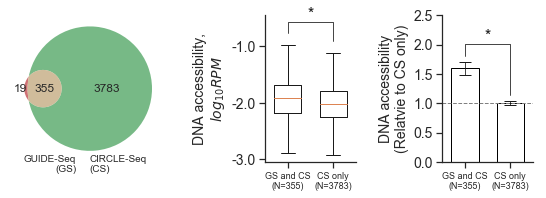

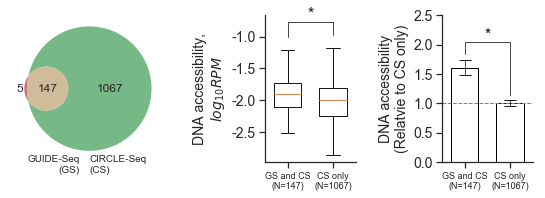

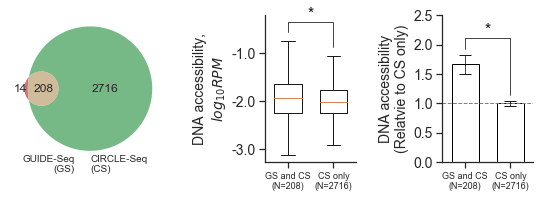

In [15]:
drawfig1(dfG4, dfF4, 'all')

dfGHEK = dfG4[dfG4['target_name'].str.contains('HEK')]
dfGU2OS = dfG4[-dfG4['target_name'].str.contains('HEK')]
dfCHEK = dfF4[dfF4['target_name'].str.contains('HEK')]
dfCU2OS = dfF4[-dfF4['target_name'].str.contains('HEK')]

drawfig1(dfGHEK, dfCHEK, 'HEK')
drawfig1(dfGU2OS, dfCU2OS, 'U2OS')

In [16]:
def calDis(p, points):
    coord = points[:, :2] - p
    dis = np.sqrt(np.sum(coord**2, axis=1))
    matr = np.stack((dis, points[:,2]), axis=-1)
    matr = pd.DataFrame(matr)
    matr.columns = ['distance', 'logcpm']
    dfTmp = matr.sort_values(by='distance', ascending = True).head(15)
    dfTmp = dfTmp[~(dfTmp['distance']==0)]
    return ((dfTmp['logcpm'] / dfTmp['distance']).sum() / ((1/dfTmp['distance'])).sum())

def gridzaxis(df):
    xaxis = 'CFD'
    yaxis = 'logCov'
    X = df[xaxis]
    Y = df[yaxis]

    grid_x, grid_y = np.mgrid[0:1:70j, -4:0:70j]
    grid_shape = grid_x.shape
    #print(X.min(), X.max(), Y.min(), Y.max())
    points2d = df.loc[:, [xaxis, yaxis]].values
    points3d = df.loc[:, [xaxis, yaxis, 'logcpm']].values
    #points2d = df.values(columns=[xaxis, yaxis])
    #points3d = df.values(columns=[xaxis, yaxis, 'logcpm'])
    dises = []
    for x, y in zip(grid_x.flatten(), grid_y.flatten()):

        dis = calDis(np.asarray([x, y]), points3d)
        dises.append(dis)

    dises = np.asarray(dises)
    dises = np.reshape(dises, grid_shape)
    return grid_x, grid_y, dises

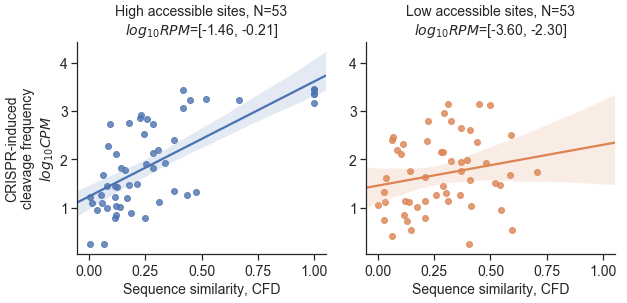

In [17]:
sortvar = 'logCov'
compare = 'CFD'
dfG_tmp = dfG4[dfG4['inguide']==1].sort_values(by=sortvar, ascending=False).reset_index(drop=True)

fig, axes = plt.subplots(1,2, figsize=(9,4.5))

axes[0].set_xlim(-.05, 1.05)
axes[1].set_xlim(-.05, 1.05)
#axes[1].set_xlim(-3.5, -0.5)
sbn.regplot(data=dfG_tmp.iloc[:53,:], x=compare, y='logcpm', ax= axes[0])
sbn.regplot(data=dfG_tmp.iloc[-53:,:], x=compare, y='logcpm', ax= axes[1])

#axes[0].plot(dfG_tmp.loc[0, 'CFD'], dfG_tmp.loc[0, 'logcpm'], 'r^', markersize=13)
#axes[0].text(dfG_tmp.loc[0, 'CFD']-.6, dfG_tmp.loc[0, 'logcpm']-1, 'HEKgRNA_site3,\nCFD=%.1f' % dfG_tmp.loc[0, 'CFD'], fontsize=11)

ylim = axes[0].get_ylim()
axes[1].set_ylim(ylim)


#xticks = axes[0].get_xticks()
#axes[0].set_xticklabels(['10$^{%.0f}$' % i for i in xticks])
#axes[1].set_xticklabels(['10$^{%.0f}$' % i for i in xticks])


#axes[1].set_yticklabels([])
#axes[0].set_xlabel('DNA accessibility, RPM\n(DNase-Seq)')

axes[0].set_xlabel('Sequence similarity, CFD')
axes[1].set_xlabel('Sequence similarity, CFD')
axes[0].set_ylabel('CRISPR-induced\ncleavage frequency\n$log_{10}CPM$')
axes[1].set_ylabel('')

axes[0].set_title('High accessible sites, N=53\n$log_{10}RPM$=[%.2f, %.2f]' % (dfG_tmp.loc[53, sortvar], dfG_tmp.loc[0, sortvar]))
axes[1].set_title('Low accessible sites, N=53\n$log_{10}RPM$=[%.2f, %.2f]' % (dfG_tmp.loc[dfG_tmp.shape[0]-1, sortvar], dfG_tmp.loc[dfG_tmp.shape[0]-53, sortvar]))
sbn.despine()

#dfG_tmp.iloc[100:152, :]
fig.tight_layout()
fig.savefig('../paper_figures/%s_GSCS_HighLowAccess_regres.png' % (curdate), dpi=600)

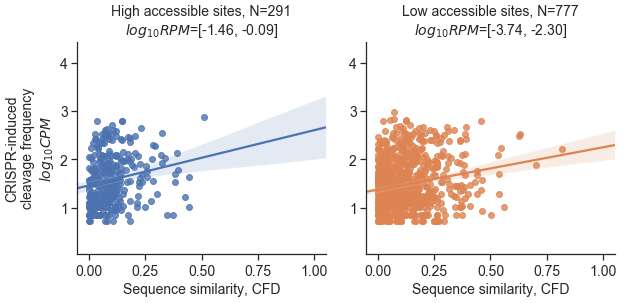

In [18]:
sortvar = 'logCov'
compare = 'CFD'

dfF_tmp = dfF4[dfF4['inguide']==0].sort_values(by=sortvar, ascending=False).reset_index(drop=True)

fig, axes = plt.subplots(1,2, figsize=(9,4.5))

axes[0].set_xlim(-.05, 1.05)
axes[1].set_xlim(-.05, 1.05)
dfF_High = dfF_tmp[dfF_tmp['logCov']>-1.46]
dfF_Low  = dfF_tmp[(dfF_tmp['logCov']>-3.6) & (dfF_tmp['logCov']<-2.3)]
sbn.regplot(data=dfF_tmp[dfF_tmp['logCov']>-1.46],  x=compare, y='logcpm', ax= axes[0])
sbn.regplot(data=dfF_tmp[(dfF_tmp['logCov']>-3.6) & (dfF_tmp['logCov']<-2.3)], x=compare, y='logcpm', ax= axes[1])

#axes[0].plot(dfF_tmp.loc[1, 'logCov'], dfF_tmp.loc[1, 'logcpm'], 'rs', markersize=10)
#axes[0].text(dfF_tmp.loc[1, 'logCov']-.35, dfF_tmp.loc[1, 'logcpm']+.4, 'HEKgRNA_site3,\nCFD=%.3f' % dfF_tmp.loc[1, 'CFD'], fontsize=11)

axes[0].set_ylim(ylim)
axes[1].set_ylim(ylim)

#axes[0].set_xticklabels(['10$^{%.0f}$' % i for i in xticks])
#axes[1].set_xticklabels(['10$^{%.0f}$' % i for i in xticks])
#axes[0].set_xlim(xlim)
#axes[1].set_xlim(xlim)

#axes[0].set_xlabel('DNA accessibility, RPM\n(DNase-Seq)')

axes[0].set_xlabel('Sequence similarity, CFD')
axes[1].set_xlabel('Sequence similarity, CFD')
axes[0].set_ylabel('CRISPR-induced\ncleavage frequency\n$log_{10}CPM$')
axes[1].set_ylabel('')
highN = dfF_High.shape[0]
lowN  = dfF_Low.shape[0]
axes[0].set_title('High accessible sites, N=%d\n$log_{10}RPM$=[%.2f, %.2f]' % (highN, dfF_tmp.loc[highN, sortvar], dfF_tmp.loc[0, sortvar]))
axes[1].set_title('Low accessible sites, N=%d\n$log_{10}RPM$=[%.2f, %.2f]' % (lowN, dfF_tmp.loc[dfF_tmp.shape[0]-1, sortvar], dfF_tmp.loc[dfF_tmp.shape[0]-lowN, sortvar]))

sbn.despine()
fig.tight_layout()
fig.savefig('../paper_figures/%s_CSonly_HighLowHomology_regres.png' % (curdate), dpi=600)

In [19]:
def plt3ddot(ax, found, s, zmax, zmin, offset):
    ax.scatter(found['logCov'], found['CFD'], found['logcpm'], s=s)
    ax.set_xlim3d(-3.5,-0.5)
    ax.tick_params(which='major', direction='out', pad=-1.5, labelsize=7)
    ax.set_ylabel('Sequence\nSimilarity, CFD', labelpad=2, rotation=30)
    ax.set_xlabel('DNA accessibility,\n$log_{10}RPM$', labelpad=9)
    ax.set_zlabel('CRISPR-induced\ncleavage frequency,\n$log_{10}CPM$', labelpad=4)
    ax.set_xlim3d(-4.2,0.2)
    ax.set_zlim3d(zmin-.2, zmax+.2)
    print(zmin, zmax)
    ax.set_ylim3d(-.05, 1.05)
    ax.text(1.2, -.15, zmin-0.35, 'Low', rotation=90, size=9)
    ax.text(1.3, 0.8, zmin-0.35, 'High', rotation=90,  size=9)
    ax.text(-3.8, -.4, zmin-0.35, 'Low', rotation=90, size=9)
    ax.text(0.7, -0.4, zmin-0.35, 'High', rotation=90,  size=9)
    ax.view_init(30,-50)
    return ax

def plt3dsrf(fig, ax, xx, yy, zz, zmax, zmin, offset):
    surf = ax.plot_surface(xx,yy,zz, rstride=1, cstride=1, cmap=cm.jet, linewidth=0 )#, alpha=0.2)
    ax.view_init(30,-50)
    ax.tick_params(which='major', direction='out', pad=-1.5, labelsize=7)
    ax.set_ylabel('Sequence\nSimilarity, CFD', labelpad=2, rotation=30)
    ax.set_xlabel('DNA accessibility,\n$log_{10}RPM$', labelpad=9)
    ax.set_zlabel('CRISPR-induced\ncleavage frequency,\n$log_{10}CPM$', labelpad=4)
    ax.set_ylim3d(-.05, 1.05)
    ax.set_zlim3d(zmin-.2, zmax+.2)
    ax.text(1.2, -.15, zmin-0.35, 'Low', rotation=90, size=9)
    ax.text(1.3, 0.8, zmin-0.35, 'High', rotation=90,  size=9)
    ax.text(-3.8, -.4, zmin-0.35, 'Low', rotation=90, size=9)
    ax.text(0.7, -0.4, zmin-0.35, 'High', rotation=90,  size=9)
    return surf, ax

In [20]:
def drawfig2(dfin, inguide=1, celltype=None, offset=0):
    dfGCboth = dfin[dfin['inguide']==inguide]
    grid_x, grid_y, redises = gridzaxis(dfGCboth)
    zmax = dfGCboth['logcpm'].max()
    zmin = dfGCboth['logcpm'].min()
    fig ,axes = plt.subplots(1,2, figsize=(9,3.5), subplot_kw=dict(projection='3d'))
    fig.subplots_adjust(left=0, bottom=0.13, right=0.9, top=1,  wspace=0.2, hspace=0)
    axes[0] = plt3ddot(axes[0], dfGCboth, 12, zmax, zmin, offset=offset)#-.2)

    surf, axes[1] = plt3dsrf(fig, axes[1], grid_y, grid_x, redises, zmax, zmin, offset=offset)#-.2)
    if celltype:
        fig.savefig('../paper_figures/%s_plot3d.%s.png' % (curdate, celltype), dpi=600)

0.24224999846 3.60529759298
0.438460724729 3.53432717821
0.24224999846 3.60529759298


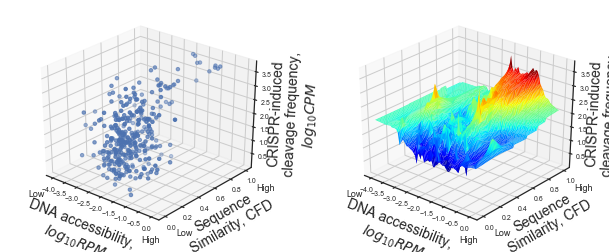

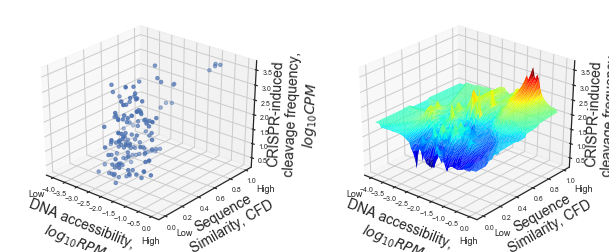

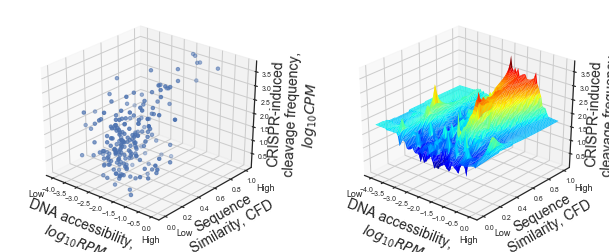

In [21]:
drawfig2(dfG4, 1, 'GS_all', offset=6)
drawfig2(dfGHEK, 1,  'GS_HEK', offset=6)
drawfig2(dfGU2OS, 1, 'GS_U2OS', offset=6)

0.539195600719 3.12420246333
1.04052071606 3.12420246333
0.539195600719 3.10258800503


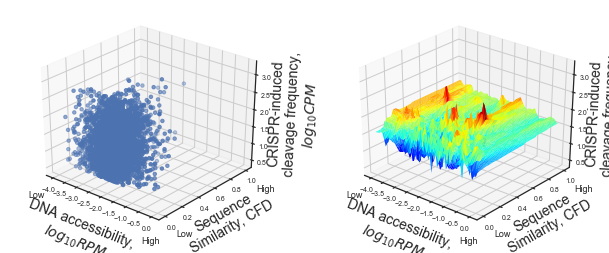

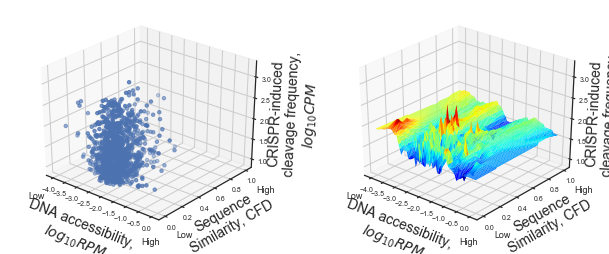

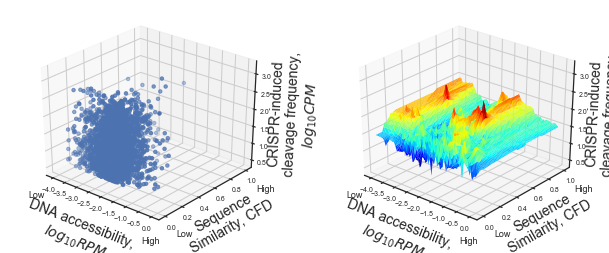

In [22]:
drawfig2(dfF4, 0, 'CS_all', offset=6)
drawfig2(dfCHEK, 0, 'CS_HEK', offset=6)
drawfig2(dfCU2OS, 0, 'CS_U2OS', offset=6)

# Stepwise correlation coefficient test

In [23]:
def slide_quantile(df, percentile, step_size=1):
    cuts = [df['logCov'].quantile(q=i, interpolation = 'linear') 
            for i in np.arange(0, 1.005, step_size*0.01)[::-1]]
    range_idx = int(percentile / step_size)
    iter_idx = len(cuts) - range_idx
    per10 = []
    for i, c in enumerate(cuts[:(iter_idx)]):
        dfTmp = df[(df['logCov']<=c) & (df['logCov']>=cuts[i+range_idx])]
        slope, intercept, r_value, p_value, std_err = stats.linregress(dfTmp['CFD'],dfTmp['logcpm'])
        per10.append({'slope': slope,
                        'intercept': intercept,
                        'r_value': r_value,
                        'p_value': p_value,
                        'std_err': std_err,
                        'cut_upper': c,
                        'cut_lower': cuts[i+range_idx]})
    return per10

def pickSig(df, cutoff = 0.01):
    sig = []
    for idx, row in df.iterrows():
        if row['p_value'] < cutoff:
            sig.append(row['normedSlope'])
        else:
            sig.append(np.nan)
    return sig

def genSlopeBound(dfinG, dfinC):
    dfGPer10 = pd.DataFrame(slide_quantile(dfinG[dfinG['inguide']==1], 15, 1))
    dfGPer10['normedSlope'] = dfGPer10['slope'] / dfGPer10.loc[0, 'slope']
    dfGPer10['sigNormedSlope'] = pickSig(dfGPer10)

    dfCPer10 = pd.DataFrame(slide_quantile(dfinC[dfinC['inguide']==0], 15, 1))
    dfCPer10['normedSlope'] = dfCPer10['slope'] / dfCPer10.loc[0, 'slope']
    dfCPer10['sigNormedSlope'] = pickSig(dfCPer10)
    upper_bound_idx = dfGPer10['sigNormedSlope'].loc[dfGPer10['sigNormedSlope'].isnull()].index[0]
    upper_bound = dfGPer10['cut_lower'].iloc[upper_bound_idx]
    lower_bound_idx = dfGPer10['sigNormedSlope'].loc[~dfGPer10['sigNormedSlope'].isnull()].index[-1]
    lower_bound = dfGPer10['cut_lower'].iloc[lower_bound_idx]
    #print("lower bound:%.2f, upper bound:%.2f" % (lower_bound, upper_bound))
    return dfGPer10, dfCPer10, upper_bound, lower_bound

In [24]:
def drawContour(fig, ax, grid_y, grid_x, redises, lower_bound, upper_bound, bound=False):
    CS = ax.contourf(grid_y, grid_x, redises, 15, cmap=cm.jet, origin='lower')
    #CS2 = ax.contour(CS, levels = CS.levels[:11], origin='lower')
    CS2 = ax.contour(grid_y, grid_x, redises, levels = CS.levels, origin='upper')

    for c in CS2.collections:
        c.set_edgecolor("face")
    ax.set_xlim(-4, -1)
    #print(len(CS.levels))
    #print(len(CS2.levels))
    #cbar = fig.colorbar(CS)
    #cbar.set_label('CRISPR-induced cleavage frequency')
    #cbar.add_lines(linewidths=[0]*len(CS.levels))
    #ax.clabel(CS2, CS2.levels, fmt='%2.2f', fontsize=17, colors='black')
    ax.set_ylabel('CFD')
    ax.set_xlabel('')
    ax.set_xticks(range(-4,0))#ax.get_xticks()
    print('see the xticks from contour')
    print(ax.get_xticks())
    ax.set_xticklabels(['%.1f' % i for i in ax.get_xticks()])
    if bound:
        ax.vlines(x=lower_bound, ymin=0, ymax=1, colors='dimgray', linestyles='dashed')
        ax.vlines(x=upper_bound, ymin=0, ymax=1, colors='dimgray', linestyles='dashed')

    sbn.despine()
    #fig.tight_layout()
    #fig.savefig('../paper_figures/20180509_contour.png', dpi=300)
    return (CS, ax)

In [25]:
#fig, ax = plt.subplots(1,1, figsize=(8,6))
#fig, axes = plt.subplots(1,2, figsize=(8,8), gridspec_kw = {'width_ratios':[10, 1]})
#CSs, axes[0] = drawContour(fig, axes[0], grid_y, grid_x, redises, -2.03, -1.82)
#axes[1] = drawColorbar(fig, axes[1], CSs)
#axes[1].yaxis.set_ticks_position('right')

In [26]:
def genCurve(df, upper=True):
    if upper:
        return df['slope']+ 2.58*df['std_err']
    return df['slope'] - 2.58*df['std_err']


def drawRelativeSlope(fig, ax, dfGPer10, dfCPer10, 
                      lower_bound, upper_bound):
    pallete = sbn.color_palette()
    ax.plot((dfGPer10['cut_lower']), 
            dfGPer10['normedSlope'], 
            color=pallete[2], label='', linestyle='--')
    ax.plot(dfGPer10['cut_lower'],
            dfGPer10['sigNormedSlope'], linewidth=2.5,
            color=pallete[2], label='GS&CS')
    ax.plot((dfCPer10['cut_lower']), 
            dfCPer10['normedSlope'], label='CS only',
            linewidth=2.5)
    

    ax.vlines(x=lower_bound, 
              ymin=0, ymax=1.5,
              color='maroon', linestyles='solid')
    ax.vlines(x=upper_bound, 
              ymin=0, ymax=1.5,
              color='maroon', linestyles='solid')
    xticks = ax.get_xticks()
    ax.set_xticklabels(['10$^{%.1f}$' % i for i in xticks])
    ax.set_xlabel('DNA accessibility (# RPM)')
    ax.set_ylabel('Relative beta\nCFD vs. CICF')
    ax.set_ylim(0,1.5)
    ax.set_xlim(-4,0)
    ax.legend()
    sbn.despine()
    return ax
    
def drawSlope(fig, ax, dfGPer10, dfCPer10, 
              lower_bound, upper_bound):
    pallete = sbn.color_palette()
    ax.plot(dfGPer10['cut_lower'],
            dfGPer10['slope'], linewidth=2.5,
            color=pallete[2], label='GS&CS')
    ax.plot((dfCPer10['cut_lower']), 
            dfCPer10['slope'], label='CS only',
            linewidth=2.5)
    
    ax.vlines(x=lower_bound, 
              ymin=-1.5, ymax=5,
              color='maroon', linestyles='dashed')
    ax.vlines(x=upper_bound, 
              ymin=-1.5, ymax=5,
              color='maroon', linestyles='dashed')
    ax.fill_between((dfGPer10['cut_lower']), 
                    genCurve(dfGPer10, False), genCurve(dfGPer10, True),
                   alpha=0.3, color=pallete[2])
    ax.fill_between((dfCPer10['cut_lower']), 
                    genCurve(dfCPer10, False), genCurve(dfCPer10, True),
                   alpha=0.3)
    xticks = ax.get_xticks()
    ax.set_xticklabels(['10$^{%.1f}$' % i for i in xticks])
    ax.set_ylabel('Beta coefficient\n')
    ax.set_xlim(-4,0)
    ax.set_ylim(-1.5,5)
    ax.hlines(0, xmin=-4, xmax=0, linestyle='--', color='gray')
    ax.legend()
    return ax
#fig, ax = plt.subplots(1,1, figsize=(12,6))
#ax = drawSlope(fig, ax, dfGPer10, dfCPer10)

# Separate into two columns

In [27]:
def genCurve(df, upper=True):
    if upper:
        return df['slope']+ 2.58*df['std_err']
    return df['slope'] - 2.58*df['std_err']


def drawRelativeSlope(fig, ax, dfGPer10, #dfCPer10, 
                      lower_bound, upper_bound,
                      label, color_num, bound=False, ybo=0, yup=1.5):
    pallete = sbn.color_palette()
    ax.plot((dfGPer10['cut_lower']), 
            dfGPer10['normedSlope'], 
            color='grey', label='', linestyle=':')
    ax.plot(dfGPer10['cut_lower'],
            dfGPer10['sigNormedSlope'], linewidth=3.5,
            color=pallete[color_num])#, label=label)
    #ax.plot((dfCPer10['cut_lower']), 
    #        dfCPer10['normedSlope'], label='CS only',
    #        linewidth=2.5)
    ax.plot(dfGPer10['cut_lower'][0],
            dfGPer10['sigNormedSlope'][0], 
            'ko', markersize=5)
    if bound:
        ax.vlines(x=lower_bound, 
              ymin=0, ymax=1.2,
              color='dimgray', linestyles='solid')
        ax.vlines(x=upper_bound, 
              ymin=0, ymax=1.2,
              color='dimgray', linestyles='solid')
    xticks = ax.get_xticks()
    #ax.set_xticklabels(['%.1f' % i for i in xticks])
    ax.set_xlabel('DNA accessibility, $log_{10}RPM$')
    ax.set_ylabel(r'Relative $\beta$' + '\n')
    ax.set_ylim(ybo,yup)
    ax.set_xlim(-4,-1)
    #ax.legend()
    #ax.set_title(label)
    sbn.despine()
    return ax
    
def drawSlope(fig, ax, dfGPer10,#, dfCPer10, 
              lower_bound, upper_bound,
              label, color_num, bound=False):
    pallete = sbn.color_palette()
    ax.plot(dfGPer10['cut_lower'],
            dfGPer10['slope'], linewidth=2.5,
            color=pallete[color_num])#, label='GS&CS')
    #ax.plot((dfCPer10['cut_lower']), 
    #        dfCPer10['slope'], label='CS only',
    #        linewidth=2.5)
    if bound:
        ax.vlines(x=lower_bound, 
              ymin=-1.5, ymax=5,
              color='dimgray', linestyles='dashed')
        ax.vlines(x=upper_bound, 
              ymin=-1.5, ymax=5,
              color='dimgray', linestyles='dashed')
    ax.fill_between((dfGPer10['cut_lower']), 
                    genCurve(dfGPer10, False), genCurve(dfGPer10, True),
                   alpha=0.3, color=pallete[color_num])
    #ax.fill_between((dfCPer10['cut_lower']), 
    #                genCurve(dfCPer10, False), genCurve(dfCPer10, True),
    #               alpha=0.3)
    xticks = ax.get_xticks()
    #ax.set_xticklabels(['%.1f' % i for i in xticks])
    ax.set_ylabel(r'$\beta$' + ",\n" + r'$log_{10}CPM$' + '~CFD\n')
    ax.set_xlim(-4,-1)
    ax.set_ylim(-1.5,5)
    ax.hlines(0, xmin=-4, xmax=0, linestyle='--', color='gray')
    #ax.legend()
    return ax
#fig, ax = plt.subplots(1,1, figsize=(12,6))
#ax = drawSlope(fig, ax, dfGPer10, dfCPer10)

In [28]:
def drawfig3(dfinG, dfinC, celltype=None):
    CSs = []
    dfGPer10, dfCPer10, upper_bound, lower_bound = genSlopeBound(dfinG, dfinC)
    dfinG = dfinG[dfinG['inguide']==1]
    dfinC = dfinC[dfinC['inguide']==0]
    for dfin, dfPer, label, color_num, bound in zip([dfinG, dfinC], [dfGPer10, dfCPer10], ['GSCS', 'CS only'], [0, 1], [True, False]):
        fig = plt.figure(figsize=(6,5))
        grid_x, grid_y, redises = gridzaxis(dfin)
        axes = gridspec.GridSpec(3,1)
        ax1 = plt.subplot(axes[0])
        CS, ax1 = drawContour(fig, ax1, 
                              grid_y, grid_x, redises, 
                              lower_bound, upper_bound, bound
                              )
        CSs.append(CS)
        ax2 = plt.subplot(axes[1])
        ax2 = drawSlope(fig, ax2, dfPer,# dfCPer10, 
                        lower_bound, upper_bound,
                        label, color_num, bound)
        

        ax3 = plt.subplot(axes[2])
        ax3 = drawRelativeSlope(fig, ax3, dfPer,# dfCPer10,
                                lower_bound, upper_bound,
                                label, color_num, bound)
        ax3.set_xticks(ax1.get_xticks())
        ax3.set_xticklabels(ax1.get_xticklabels())
        ax2.set_xticks(ax1.get_xticks())
        ax2.set_xticklabels([])
        ax1.set_xticklabels([])
        
        ax3.text(-4, -.85, 'Low', fontsize=12)
        ax3.text(-1, -.85, 'High', fontsize=12)
        fig.tight_layout()
        if celltype:
            ax1.set_title(label)
            fig.savefig('../paper_figures/%s_boundaries.%s.%s.png' % (curdate, celltype, label), dpi=600)
    return CSs

see the xticks from contour
[-4 -3 -2 -1]
see the xticks from contour
[-4 -3 -2 -1]
see the xticks from contour
[-4 -3 -2 -1]
see the xticks from contour
[-4 -3 -2 -1]
see the xticks from contour
[-4 -3 -2 -1]
see the xticks from contour
[-4 -3 -2 -1]


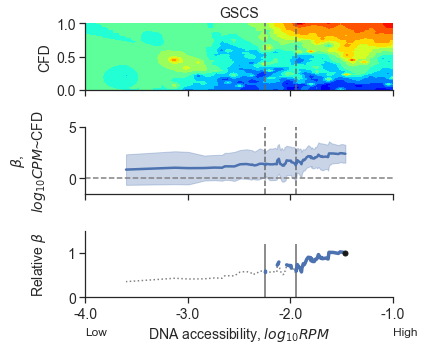

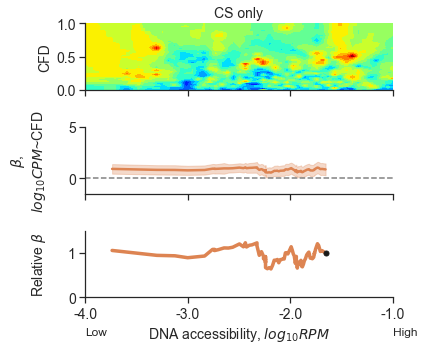

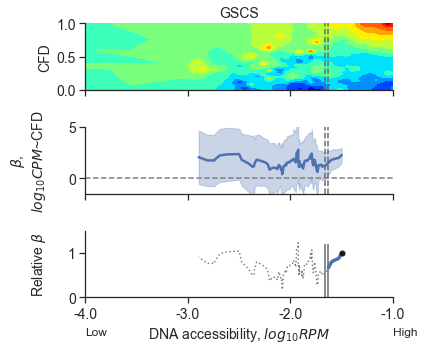

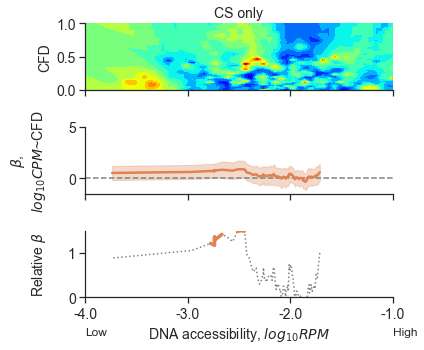

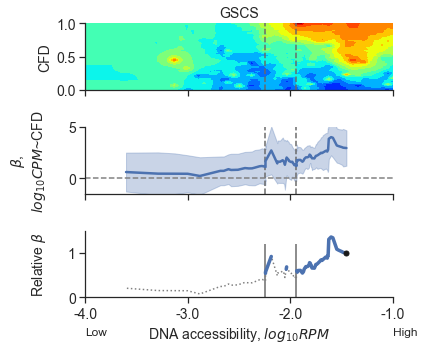

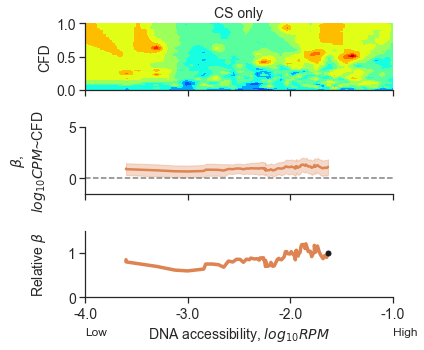

In [29]:
CSs = drawfig3(dfG4, dfF4, 'all')
drawfig3(dfGHEK, dfCHEK, 'HEK')
drawfig3(dfGU2OS, dfCU2OS, 'U2OS')

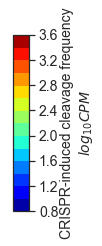

In [30]:
def drawColorbar(fig, ax, CS):
    cbar = plt.colorbar(CS, cax = ax)
    cbar.set_label('CRISPR-induced cleavage frequency\n$log_{10}CPM$')
    ax.yaxis.set_ticks_position('right')
    cbar.set_ticklabels(['%.1f' % i for i in cbar.get_ticks()])
    #ax.yaxis.set_ticks(['10$^{%.1f}$' % i for i in ax.yaxis.get_yticks()])
    return ax

fig, ax = plt.subplots(1,1, figsize=(1.5,3.5))
ax = drawColorbar(fig, ax, CSs[0])
fig.subplots_adjust(left=0.15, bottom=0.15, right=0.3, top=0.85,  wspace=0.13, hspace=0)
#fig.tight_layout()
fig.savefig('../paper_figures/%s_colorbar.png' % (curdate), dpi=600)

# Gene expression vs CRISPR cleavage with regards to DNase accessibility

In [3]:
housekeep = pd.read_csv('../raw_data/transcriptome/HK_genes.txt', sep='\t', header=-1)
housekeep.columns = ['symbol', 'refseq']

dfExpHEK = pd.read_csv('../raw_data/transcriptome/HEK/paired/SRR3997505/abundance.tsv', sep='\t')
dfExpU2  = pd.read_csv('../raw_data/transcriptome/U2OS/ERR191523_trimmed/ERR191523/abundance.tsv', sep='\t')
dfExpU2['ref'] = dfExpU2['target_id'].str.strip('|').str.strip('ref|')
dfExpHEK['ref'] = dfExpHEK['target_id'].str.strip('|').str.strip('ref|')

# Pick mRNA NM_
dfExpU2 = dfExpU2[dfExpU2['ref'].str.contains('NM_')]
dfExpHEK = dfExpHEK[dfExpHEK['ref'].str.contains('NM_')]

# Pick housekeeping genes
dfHEKhouse = dfExpHEK[dfExpHEK['ref'].apply(lambda x: x.split('.')[0]).isin(housekeep['refseq'])]
dfU2house = dfExpU2[dfExpU2['ref'].apply(lambda x: x.split('.')[0]).isin(housekeep['refseq'])]

dfExpMerge = pd.merge(left=dfExpHEK, right=dfExpU2, on='ref', how='inner')
dfExpMerge['avg_tpm'] = (dfExpMerge['tpm_x'] + dfExpMerge['tpm_y'])/2

# Take out zeros
#dfExpU2 = dfExpU2[dfExpU2['tpm']>5]
#dfExpHEK = dfExpHEK[dfExpHEK['tpm']>5]
dfExpMerge = dfExpMerge[dfExpMerge['avg_tpm']>5]
dfExpMerge.shape

(8940, 12)

In [4]:
dfExpMerge.head()

,target_id_x,length_x,eff_length_x,est_counts_x,tpm_x,ref,target_id_y,length_y,eff_length_y,est_counts_y,tpm_y,avg_tpm
3,ref|NM_152486.2|,2575,2406.45,3432.11,33.5460,NM_152486.2,ref|NM_152486.2|,2575,2475.0,386.652,2.92148,18.233740
4,ref|NM_015658.3|,2817,2648.45,11569.90,102.7530,NM_015658.3,ref|NM_015658.3|,2817,2717.0,7988.990,54.98710,78.870050
5,ref|NM_198317.2|,2581,2412.45,1528.71,14.9047,NM_198317.2,ref|NM_198317.2|,2581,2481.0,361.574,2.72539,8.815045
10,ref|NM_021170.3|,962,793.45,5300.52,157.1280,NM_021170.3,ref|NM_021170.3|,962,862.0,0.000,0.00000,78.564000
11,ref|NM_001142467.1|,1053,884.45,5273.43,140.2410,NM_001142467.1,ref|NM_001142467.1|,1053,953.0,0.000,0.00000,70.120500


In [32]:
dfU2Dseq = pd.read_csv('../raw_data/transcriptome/U2OS_990_TSS_1000up_200down_DNaseSeq.csv', index_col=0)
dfHEKDseq = pd.read_csv('../raw_data/transcriptome/HEK_TSS_1000up_200down_DNaseSeq.csv', index_col=0)
cols = list(dfHEKDseq.columns)
cols = cols[:4] + cols[-2:]

dfHEKDseq = dfHEKDseq[cols]
dfU2Dseq  = dfU2Dseq[cols]
dfDseqMerge = pd.merge(left=dfHEKDseq, right=dfU2Dseq, on='name', how='inner')
dfDseqMerge['avg_nsumCov'] = (dfDseqMerge['normed_sumCov_x']+dfDseqMerge['normed_sumCov_y'])/2


In [33]:
dfED = pd.merge(left=dfDseqMerge, right=dfExpMerge, left_on='name', right_on='ref', how='inner')
dfED = dfED[(dfED['avg_nsumCov']>0) & (dfED['avg_tpm']>5)]
dfED['log_avg_nsumCov'] = dfED['avg_nsumCov'].map(np.log10)
#dfED['log_HEKtpm'] = dfED['tpm_x'].map(np.log10)
dfED['logavgtpm'] = dfED['avg_tpm'].map(np.log10)

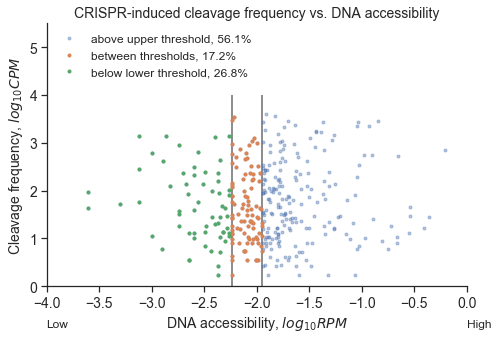

In [34]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
dfGPer10, dfCPer10, upper_bound, lower_bound = genSlopeBound(dfG4, dfF4)
dfTmp = dfG4[dfG4['inguide']==1]
dfBelow = dfTmp[dfTmp['logCov']<lower_bound]
dfBetween = dfTmp[(dfTmp['logCov']>=lower_bound) & (dfTmp['logCov']<upper_bound)]
n_above = float(dfTmp[dfTmp['logCov']>=upper_bound].shape[0])
ax.plot(dfTmp['logCov'], dfTmp['logcpm'], '.', alpha=.4, label='above upper threshold, %.1f%%' % (n_above/dfTmp.shape[0]*100))
ax.plot(dfBetween['logCov'], dfBetween['logcpm'], '.', label='between thresholds, %.1f%%'% (float(dfBelow.shape[0])/float(dfTmp.shape[0])*100))
ax.plot(dfBelow['logCov'], dfBelow['logcpm'], '.', label='below lower threshold, %.1f%%' % (float(dfBetween.shape[0])/float(dfTmp.shape[0])*100))
#sbn.regplot(x = 'logCov', y='logcpm', data=dfTmp, ax = ax, scatter_kws={'alpha':0.6, 's': 13})#, x_bins=np.linspace(-4,0,100))
ax.set_xlim(-4,0)
ax.set_ylim(0,5.5)
sbn.despine()
ax.set_title('CRISPR-induced cleavage frequency vs. DNA accessibility')
ax.set_xlabel('DNA accessibility, $log_{10}RPM$')
ax.set_ylabel('Cleavage frequency, $log_{10}CPM$')
ax.vlines(x=lower_bound, 
          ymin=0, ymax=4,
          color='dimgray')#, linestyles='dashed')
ax.vlines(x=upper_bound, 
          ymin=0, ymax=4,
          color='dimgray')#, linestyles='dashed')
ax.legend(loc='upper left', fontsize='12', edgecolor='w')
ax.text(-4, -.85, 'Low', fontsize=12)
ax.text(-0, -.85, 'High', fontsize=12)
fig.tight_layout()
#fig.savefig('../paper_figures/%s_CICFvsDNAacce.png' % curdate, dpi=600)

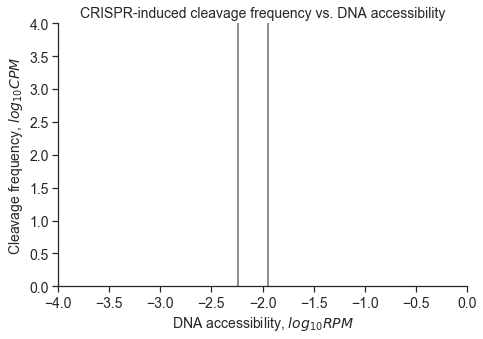

In [35]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
dfGPer10, dfCPer10, upper_bound, lower_bound = genSlopeBound(dfG4, dfF4)
dfTmp = dfG4[dfG4['inguide']==1]
#ax.plot(dfTmp['logCov'], dfTmp['logcpm'], '.', alpha=.4)
#dfTmp45 = dfTmp[dfTmp['CFD']>0.45]
#sbn.regplot(x = 'logCov', y='logcpm', data=dfTmp, ax = ax, scatter_kws={'alpha':0.2, 's': 13}, label='CFD$\geq$0')#, x_bins=np.linspace(-4,0,100))
#sbn.regplot(x = 'logCov', y='logcpm', data=dfTmp45, ax = ax, scatter_kws={'alpha':0.5, 's': 13}, label='CFD > 0.45')#, x_bins=np.linspace(-4,0,100))

ax.set_xlim(-4,0)
ax.set_ylim(0,4)
sbn.despine()
ax.set_title('CRISPR-induced cleavage frequency vs. DNA accessibility')
ax.set_xlabel('DNA accessibility, $log_{10}RPM$')
ax.set_ylabel('Cleavage frequency, $log_{10}CPM$')
ax.vlines(x=lower_bound, 
          ymin=0, ymax=4,
          color='dimgray')#, linestyles='dashed')
ax.vlines(x=upper_bound, 
          ymin=0, ymax=4,
          color='dimgray')#, linestyles='dashed')
ax.legend(loc='upper left', edgecolor='w')
#ax.legend.get_frame().set_linewidth(0)
fig.tight_layout()
#fig.savefig('../paper_figures/%s_CICFvsDNAacce_CFD45.png' % curdate, dpi=600)

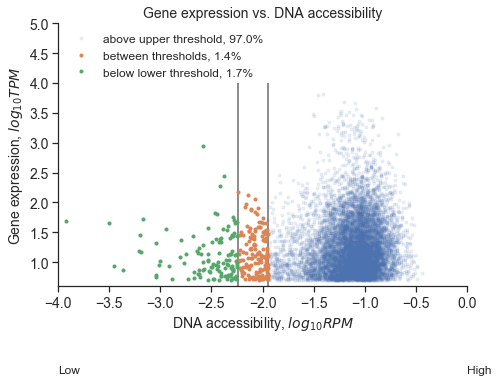

In [36]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

dfTmp = dfED.copy(deep=True)
dfBelow = dfTmp[dfTmp['log_avg_nsumCov']<lower_bound]
dfBetween = dfTmp[(dfTmp['log_avg_nsumCov']>=lower_bound) & (dfTmp['log_avg_nsumCov']<upper_bound)]
n_above = float(dfTmp[dfTmp['log_avg_nsumCov']>=upper_bound].shape[0])
ax.plot(dfTmp['log_avg_nsumCov'], dfTmp['logavgtpm'], '.', alpha=.1, label='above upper threshold, %.1f%%' % (n_above/dfTmp.shape[0]*100))
ax.plot(dfBetween['log_avg_nsumCov'], dfBetween['logavgtpm'], '.', label='between thresholds, %.1f%%'% (float(dfBelow.shape[0])/float(dfTmp.shape[0])*100))
ax.plot(dfBelow['log_avg_nsumCov'], dfBelow['logavgtpm'], '.', label='below lower threshold, %.1f%%' % (float(dfBetween.shape[0])/float(dfTmp.shape[0])*100))

#ax.plot(dfED['log_avg_nsumCov'], dfED['logavgtpm'], '.', alpha=0.1)
#sbn.regplot(x = 'log_avg_nsumCov', y='logavgtpm', data=dfED, ax = ax, x_bins=np.linspace(-4,0,100), scatter_kws={'alpha':0.3, 's': 13})
#sbn.kdeplot(dfED['log_avg_nsumCov'])

ax.set_xlim(-4,0)
ax.set_ylim(0.6,5)
sbn.despine()
ax.set_title('Gene expression vs. DNA accessibility')
ax.set_xlabel('DNA accessibility, $log_{10}RPM$')
ax.set_ylabel('Gene expression, $log_{10}TPM$')
ax.vlines(x=lower_bound, 
          ymin=0, ymax=4,
          color='dimgray')#, linestyles='dashed')
ax.vlines(x=upper_bound, 
          ymin=0, ymax=4,
          color='dimgray')#, linestyles='dashed')
ax.legend(loc='upper left', fontsize=12, edgecolor='w')
ax.text(-4, -.85, 'Low', fontsize=12)
ax.text(-0, -.85, 'High', fontsize=12)
fig.tight_layout()
#fig.savefig('../paper_figures/%s_GEvsDNAacce.png' % curdate, dpi=600)

# Figure for original manuscript

[-4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0. ]


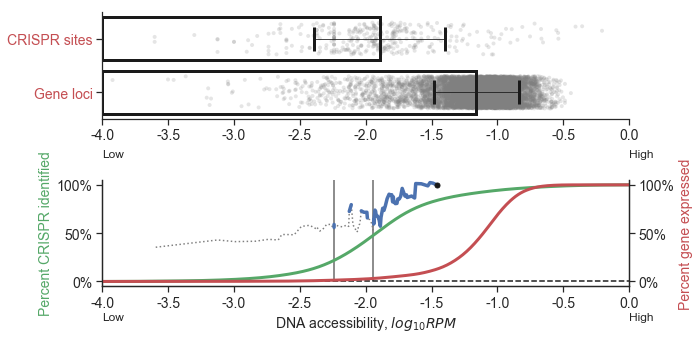

In [46]:
fig, axes = plt.subplots(2,1, figsize=(10,5))
x = np.linspace(-4, 0, 400)
dfGPer10, dfCPer10, upper_bound, lower_bound = genSlopeBound(dfG4, dfF4)
axes[1] = drawRelativeSlope(fig, axes[1], dfGPer10, lower_bound, upper_bound, 'all_GSandCS', 0, bound=True, ybo=-.05, yup=1.05)

dfGin = dfG4[dfG4['inguide']==1]
GKDE = stats.gaussian_kde(dfGin['logCov'])
Gpdf = GKDE.pdf(x)
axes[1].plot(x, np.cumsum(Gpdf)/np.sum(Gpdf), color=sbn.color_palette()[2], linewidth=3)
axes[1].set_xlim(-4,0)
#ax.set_ylim(-.4, 1.1)

xticks = axes[1].get_xticks()
print(xticks)
axes[1].set_xticklabels(['10$^{%.1f}$' % i for i in xticks])
yticks = axes[1].get_yticks()
axes[1].set_yticklabels(['%d%%' % (i*100) for i in yticks])

ax2 = axes[1].twinx()
ExpDseqKDE = stats.gaussian_kde(dfED['log_avg_nsumCov'])
EDpdf = ExpDseqKDE.pdf(x)
ax2.plot(x, np.cumsum(EDpdf)/np.sum(EDpdf), color='r', linewidth=3)
ax2.set_ylabel('Percent gene expressed', color='r')#, fontsize=20)
#ax2.set_ylim(-.4, 1.1)
yticks2 = ax2.get_yticks()
#print(ax.get_xticks())
ax2.set_yticklabels(['%d%%' % (i*100) for i in yticks2])

#axes[1].hlines(y=0, xmin=-4, xmax=0, color='k', linestyles='dashed')
ax2.hlines(y=0, xmin=-4, xmax=0, color='k', linestyles='dashed')
axes[1].set_yticklabels(['%d%%' % (i*100) for i in yticks])
axes[1].set_ylabel('Percent CRISPR identified', color=sbn.color_palette()[2])#, fontsize=20)
sbn.despine(ax=axes[1], right=False, left=False)
sbn.despine(ax=ax2, right=False, left=False)
#axes[1]=ax

DofCRIS = dfGin['logCov']
DofGENE = dfED['log_avg_nsumCov']

sbn.stripplot(data=[DofCRIS, DofGENE], orient='h', 
              jitter=0.3, alpha=0.2, 
              zorder=1, ax=axes[0],
              size=4, color='grey') #palette='grey')
axes[0].barh(range(2), [DofCRIS.mean()+4, DofGENE.mean()+4], 
        left=-4, orientation='horizontal', 
        color='', edgecolor=['k', 'k'],
        linewidth=3, zorder=2)
axes[0].errorbar(x=[DofCRIS.mean(), DofGENE.mean()], y=range(2), xerr=[DofCRIS.std(), DofGENE.std()],
            linestyle=' ', elinewidth=.8, linewidth=5,
            capsize=12, capthick=3, color='k')#)color=sbn.color_palette()[2])# color=[tuple(list(x)+[1]) for x in sbn.color_palette()[2:4]])
axes[0].set_xlim(-4,0)
axes[0].set_yticklabels(['CRISPR sites', 'Gene loci'], color='r')
axes[0].set_xlabel('')
axes[1].set_xlabel('DNA accessibility, $log_{10}RPM$')

axes[0].set_xticklabels(['%.1f' % i for i in xticks])
axes[0].text(-4, 2.2, 'Low', fontsize=12)
axes[0].text(-0, 2.2, 'High', fontsize=12)
axes[1].set_xticklabels(['%.1f' % i for i in xticks])
axes[1].text(-4, -.4, 'Low', fontsize=12)
axes[1].text(-0, -.4, 'High', fontsize=12)
fig.tight_layout()
fig.savefig('../paper_figures/%s_CRISPRvsGeneExp_MeanStripPlot.png'% curdate, dpi=600)

In [82]:
10**-(DofCRIS.mean()-DofGENE.mean())

5.432392714464294

## t-test, DNA accessibility between CRISPR and Gene

In [38]:
dfGin = dfG4[dfG4['inguide']==1]
stats.ttest_ind(dfGin['logCov'], dfED['log_avg_nsumCov'])

Ttest_indResult(statistic=-40.941678807742534, pvalue=0.0)

# Percent on the thresholds

In [39]:
upper_bound, lower_bound

(-1.9461510016173129, -2.2402122952096302)

In [40]:
x = np.linspace(-4, 0, 400)
np.interp(upper_bound, x, np.cumsum(Gpdf)/np.sum(Gpdf))

0.4743710739124632

In [41]:
x = np.linspace(-4, 0, 400)
np.interp(lower_bound, x, np.cumsum(Gpdf)/np.sum(Gpdf))

0.21841295066180672

In [42]:
x = np.linspace(-4, 0, 400)
np.interp(upper_bound, x, np.cumsum(EDpdf)/np.sum(EDpdf))

0.03063189202099102

In [43]:
x = np.linspace(-4, 0, 400)
np.interp(lower_bound, x, np.cumsum(EDpdf)/np.sum(EDpdf))

0.013494328350547088

# Analysis for HEK293T cell

In [79]:
dfEDHEK = pd.merge(left=dfHEKDseq, right=dfExpHEK, left_on='name', right_on='ref', how='inner')
dfEDHEK = dfEDHEK[(dfEDHEK['normed_sumCov']>0) & (dfEDHEK['tpm']>5)]
dfEDHEK['log_nsumCov'] = dfEDHEK['normed_sumCov'].map(np.log10)
dfEDHEK['logtpm'] = dfEDHEK['tpm'].map(np.log10)

[-0.2  0.   0.2  0.4  0.6  0.8  1.   1.2]


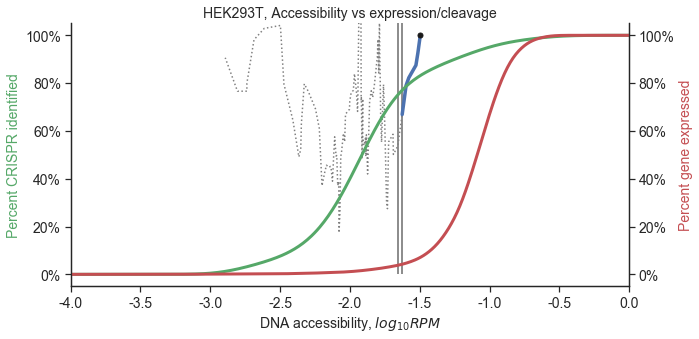

In [80]:
## Only HEK293T

fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.linspace(-4, 0, 400)
dfGPer10, dfCPer10, upper_bound, lower_bound = genSlopeBound(dfGHEK, dfCHEK)
ax = drawRelativeSlope(fig, ax, dfGPer10, lower_bound, upper_bound, 'all_GSandCS', 0, bound=True, ybo=-.05, yup=1.05)
ax.set_xlim(-4,0)
xticks = ax.get_xticks()

ax.set_xticklabels(['%.1f' % i for i in xticks])
dfGin = dfGHEK[dfGHEK['inguide']==1]
GKDE = stats.gaussian_kde(dfGin['logCov'])
Gpdf = GKDE.pdf(x)
ax.plot(x, np.cumsum(Gpdf)/np.sum(Gpdf), color=sbn.color_palette()[2], linewidth=3)

ax2 = ax.twinx()
ExpDseqKDE = stats.gaussian_kde(dfEDHEK['log_nsumCov'])

EDpdf = ExpDseqKDE.pdf(x)
ax2.plot(x, np.cumsum(EDpdf)/np.sum(EDpdf), 'r', linewidth=3)
ax2.set_ylabel('Percent gene expressed', color='r')
yticks = ax2.get_yticks()
print(yticks)
ax2.set_yticklabels(['%d%%' % (i*100) for i in yticks])
ax.set_yticklabels(['%d%%' % (i*100) for i in yticks])
ax.set_ylabel('Percent CRISPR identified', color=sbn.color_palette()[2])
sbn.despine(ax=ax, right=False, left=False)
sbn.despine(ax=ax2, right=False, left=False)
ax.set_title('HEK293T, Accessibility vs expression/cleavage')
fig.tight_layout()
fig.savefig('../paper_figures/%s_CRISPRvsGeneExp_HEKonly.png'% curdate, dpi=600)

# Analysis for U2OS cell

In [81]:
dfEDU2 = pd.merge(left=dfU2Dseq, right=dfExpU2, left_on='name', right_on='ref', how='inner')
dfEDU2 = dfEDU2[(dfEDU2['normed_sumCov']>0) & (dfEDU2['tpm']>5)]
dfEDU2['log_nsumCov'] = dfEDU2['normed_sumCov'].map(np.log10)
dfEDU2['logtpm'] = dfEDU2['tpm'].map(np.log10)

[-0.2  0.   0.2  0.4  0.6  0.8  1.   1.2]


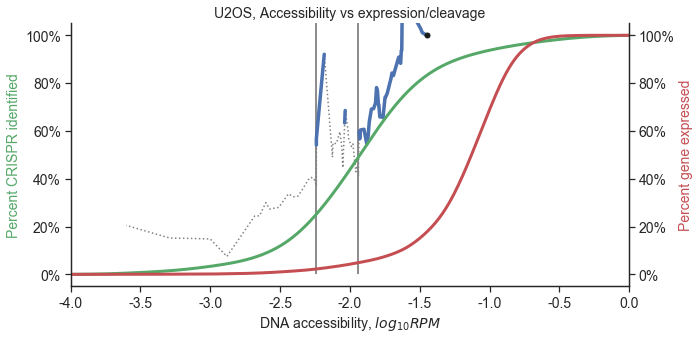

In [82]:
## Only U2OS

fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.linspace(-4, 0, 400)
dfGPer10, dfCPer10, upper_bound, lower_bound = genSlopeBound(dfGU2OS, dfCU2OS)
ax = drawRelativeSlope(fig, ax, dfGPer10, lower_bound, upper_bound, 'all_GSandCS', 0, bound=True, ybo=-.05, yup=1.05)
ax.set_xlim(-4,0)
xticks = ax.get_xticks()

ax.set_xticklabels(['%.1f' % i for i in xticks])
dfGin = dfGU2OS[dfGU2OS['inguide']==1]
GKDE = stats.gaussian_kde(dfGin['logCov'])
Gpdf = GKDE.pdf(x)
ax.plot(x, np.cumsum(Gpdf)/np.sum(Gpdf), color=sbn.color_palette()[2], linewidth=3)

ax2 = ax.twinx()
ExpDseqKDE = stats.gaussian_kde(dfEDU2['log_nsumCov'])

EDpdf = ExpDseqKDE.pdf(x)
ax2.plot(x, np.cumsum(EDpdf)/np.sum(EDpdf), 'r', linewidth=3)
ax2.set_ylabel('Percent gene expressed', color='r')
yticks = ax2.get_yticks()
print(yticks)
ax2.set_yticklabels(['%d%%' % (i*100) for i in yticks])
ax.set_yticklabels(['%d%%' % (i*100) for i in yticks])
ax.set_ylabel('Percent CRISPR identified', color=sbn.color_palette()[2])
sbn.despine(ax=ax, right=False, left=False)
sbn.despine(ax=ax2, right=False, left=False)
ax.set_title('U2OS, Accessibility vs expression/cleavage')
fig.tight_layout()
fig.savefig('../paper_figures/%s_CRISPRvsGeneExp_U2only.png'% curdate, dpi=600)

# Simple linear regression

In [47]:
from scipy import stats
from statsmodels.formula.api import ols
from itertools import product

In [48]:
def fitlinreg(formula, df):
    model = ols(formula, df).fit()
    return model

In [49]:
def genLin(dfIn1, dfIn2):
    columns = ['data', 'formula', 'parameters', 'coefficient', 'pvalues', 'low_bound', 'up_bound', 'rsqr', 'rsqr_adj', 'llf']
    dfLinReg = pd.DataFrame(columns = columns)
    dfLinReg.shape
    dfCSonly = dfIn2[dfIn2['inguide']==0]
    dfGSCS   = dfIn1[dfIn1['inguide']==1]
    #dfGSCS = dfG4[dfG4['Mismatches']<5]
    st = ['dfCSonly']*4 + ['dfGSCS'] *4 #['dfFinal']*3 + 

    forms = ["logcpm ~ CFD", "logcpm ~ normedLogCov", "logcpm ~ CFD + normedLogCov", "logcpm ~ CFD * normedLogCov"]
    dfs = [dfCSonly, dfGSCS]
    for n, (d, f) in zip(st, product(dfs, forms)):
        test1 = fitlinreg(f, d)
        print(test1.summary())
        da = [n, f, test1.params.index[1:].values, 
              test1.params[1:].values,
              test1.pvalues[1:].values,
              test1.conf_int()[0][1:].values,
              test1.conf_int()[1][1:].values,
              test1.rsquared,
              test1.rsquared_adj,
              test1.llf]
        dfLinReg.loc[dfLinReg.shape[0]] = da

    dfLinReg['deltaLLF'] = dfLinReg.groupby('data')['llf'].apply(lambda x: x-x.values[0])
    tmpDOF = dfLinReg.groupby('data')['coefficient'] #.apply(lambda x: len(list(x)))
    dofs = []
    for t in tmpDOF:    
        s = t[1].apply(lambda x: len(x))
        dofs.append(s)
        
    dfLinReg['DOF'] = np.concatenate((dofs[0], dofs[1]))

    def f(x):
        return stats.chi2.sf(x['deltaLLF'], x['DOF'])
    dfLinReg['chi2test_pvalue'] = dfLinReg.apply(f, axis=1)
    return dfLinReg

In [50]:
def genLinHomo(dfIn1, dfIn2):
    columns = ['data', 'formula', 'parameters', 'coefficient', 'pvalues', 'low_bound', 'up_bound', 'rsqr', 'rsqr_adj', 'llf']
    dfLinReg = pd.DataFrame(columns = columns)
    dfLinReg.shape
    dfCSonly = dfIn2[dfIn2['inguide']==0]
    dfGSCS   = dfIn1[dfIn1['inguide']==1]
    #dfGSCS = dfG4[dfG4['Mismatches']<5]
    st = ['dfCSonly']*4 + ['dfGSCS'] *4 #['dfFinal']*3 + 

    forms = ["logcpm ~ normedLogCov", "logcpm ~ logCFD + normedLogCov", "logcpm ~ logCFD * normedLogCov"]
    dfs = [dfCSonly, dfGSCS]
    for n, (d, f) in zip(st, product(dfs, forms)):
        test1 = fitlinreg(f, d)
        
        da = [n, f, test1.params.index[1:].values, 
              test1.params[1:].values,
              test1.pvalues[1:].values,
              test1.conf_int()[0][1:].values,
              test1.conf_int()[1][1:].values,
              test1.rsquared,
              test1.rsquared_adj,
              test1.llf]
        dfLinReg.loc[dfLinReg.shape[0]] = da

    dfLinReg['deltaLLF'] = dfLinReg.groupby('data')['llf'].apply(lambda x: x-x.values[0])
    tmpDOF = dfLinReg.groupby('data')['coefficient'] #.apply(lambda x: len(list(x)))
    dofs = []
    for t in tmpDOF:    
        s = t[1].apply(lambda x: len(x))
        dofs.append(s)
        
    dfLinReg['DOF'] = np.concatenate((dofs[0], dofs[1]))

    def f(x):
        return stats.chi2.sf(x['deltaLLF'], x['DOF'])
    dfLinReg['chi2test_pvalue'] = dfLinReg.apply(f, axis=1)
    return dfLinReg

In [51]:
dfLinAll = genLin(dfG4, dfF4)
dfLinAll

                            OLS Regression Results                            
Dep. Variable:                 logcpm   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     105.9
Date:                Mon, 01 Apr 2019   Prob (F-statistic):           1.65e-24
Time:                        12:34:42   Log-Likelihood:                -2944.6
No. Observations:                3783   AIC:                             5893.
Df Residuals:                    3781   BIC:                             5906.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4286      0.012    114.973      0.0

,data,formula,parameters,coefficient,pvalues,low_bound,up_bound,rsqr,rsqr_adj,llf,deltaLLF,DOF,chi2test_pvalue
0,dfCSonly,logcpm ~ CFD,[CFD],[0.807638545401],[1.65029183878e-24],[0.653747818486],[0.961529272315],0.027238,0.026981,-2944.588449,0.000000,1,1.000000
1,dfCSonly,logcpm ~ normedLogCov,[normedLogCov],[0.108891866689],[0.11256019951],[-0.0256204576092],[0.243404190986],0.000666,0.000401,-2995.564976,-50.976528,1,1.000000
2,dfCSonly,logcpm ~ CFD + normedLogCov,"[CFD, normedLogCov]","[0.816505976549, 0.145818481694]","[5.7650456613e-25, 0.0314378305623]","[0.662477152076, 0.0129874824682]","[0.970534801022, 0.27864948092]",0.028429,0.027915,-2942.271859,2.316590,2,0.314021
3,dfCSonly,logcpm ~ CFD * normedLogCov,"[CFD, normedLogCov, CFD:normedLogCov]","[1.00034917422, 0.19192222032, -0.404085432756]","[0.000866155894414, 0.0534126328965, 0.5256295...","[0.411979104705, -0.00282269672246, -1.6522081...","[1.58871924374, 0.386667137362, 0.844037308831]",0.028533,0.027762,-2942.070202,2.518247,3,0.472003
4,dfGSCS,logcpm ~ CFD,[CFD],[1.78928640729],[1.48753579171e-20],[1.43384022138],[2.1447325932],0.217320,0.215103,-384.190825,0.000000,1,1.000000
5,dfGSCS,logcpm ~ normedLogCov,[normedLogCov],[0.126419418912],[0.666257245933],[-0.449575736031],[0.702414573855],0.000528,-0.002304,-427.590329,-43.399504,1,1.000000
6,dfGSCS,logcpm ~ CFD + normedLogCov,"[CFD, normedLogCov]","[1.79063149704, 0.157805581635]","[1.53428791936e-20, 0.543382230913]","[1.43483765997, -0.352405597749]","[2.14642533412, 0.668016761019]",0.218142,0.213700,-384.004333,0.186492,2,0.910969
7,dfGSCS,logcpm ~ CFD * normedLogCov,"[CFD, normedLogCov, CFD:normedLogCov]","[0.386019794973, -0.53308336411, 2.57941619511]","[0.563271260247, 0.192208227307, 0.0294659747249]","[-0.926255850983, -1.33550890243, 0.258854256297]","[1.69829544093, 0.269342174208, 4.89997813393]",0.228645,0.222052,-381.603820,2.587005,3,0.459772


In [52]:
dfG_tmp = dfG4.sort_values(by='logCov', ascending=False).reset_index(drop=True)
dfF_tmp = dfF4.sort_values(by='logCov', ascending=False).reset_index(drop=True)
dfHighHomo = genLin(dfG_tmp.iloc[:53,:], dfF_tmp.iloc[:291, :])
dfLowHomo  = genLin(dfG_tmp.iloc[-53:,:], dfF_tmp.iloc[-777:, :])
#dfHighHomo.to_csv('../processed_data/%s_GSCS_HighLowHomology_regres.csv' % curdate)
#dfLowHomo.to_csv('../processed_data/%s_CSonly_HighLowHomology_regres.csv' % curdate)

                            OLS Regression Results                            
Dep. Variable:                 logcpm   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     7.348
Date:                Mon, 01 Apr 2019   Prob (F-statistic):            0.00719
Time:                        12:34:49   Log-Likelihood:                -188.38
No. Observations:                 245   AIC:                             380.8
Df Residuals:                     243   BIC:                             387.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4712      0.049     30.051      0.0

In [53]:
dfHighHomo

,data,formula,parameters,coefficient,pvalues,low_bound,up_bound,rsqr,rsqr_adj,llf,deltaLLF,DOF,chi2test_pvalue
0,dfCSonly,logcpm ~ CFD,[CFD],[0.940020808444],[0.007190833848],[0.256964456198],[1.62307716069],0.029353,0.025358,-188.383983,0.000000,1,1.000000
1,dfCSonly,logcpm ~ normedLogCov,[normedLogCov],[-0.494831797901],[0.248484878508],[-1.33741168906],[0.347748093259],0.005477,0.001384,-191.360769,-2.976786,1,1.000000
2,dfCSonly,logcpm ~ CFD + normedLogCov,"[CFD, normedLogCov]","[0.931842824463, -0.470792894661]","[0.00768835814136, 0.266224576047]","[0.248958957662, -1.3029870603]","[1.61472669126, 0.361401270978]",0.034308,0.026327,-187.756979,0.627004,2,0.730883
3,dfCSonly,logcpm ~ CFD * normedLogCov,"[CFD, normedLogCov, CFD:normedLogCov]","[2.12127747795, -0.306839072114, -1.64260575887]","[0.521340468338, 0.620997755723, 0.717586662056]","[-4.38522887676, -1.52772077451, -10.5782644694]","[8.62778383266, 0.914042630282, 7.29305295165]",0.034833,0.022819,-187.690347,0.693636,3,0.874700
4,dfGSCS,logcpm ~ CFD,[CFD],[2.22541435056],[3.43365819757e-08],[1.55901791834],[2.89181078278],0.519553,0.508114,-40.699134,0.000000,1,1.000000
5,dfGSCS,logcpm ~ normedLogCov,[normedLogCov],[0.0817941913523],[0.958312816294],[-3.05733367192],[3.22092205462],0.000066,-0.023742,-56.824537,-16.125403,1,1.000000
6,dfGSCS,logcpm ~ CFD + normedLogCov,"[CFD, normedLogCov]","[2.26744621635, 1.04975101115]","[3.13859293953e-08, 0.340481200614]","[1.59423427946, -1.14843843903]","[2.94065815324, 3.24794046133]",0.530211,0.507294,-40.205612,0.493522,2,0.781328
7,dfGSCS,logcpm ~ CFD * normedLogCov,"[CFD, normedLogCov, CFD:normedLogCov]","[1.84653130072, 0.937731774781, 0.555105283303]","[0.714365631329, 0.590214063165, 0.93330594121]","[-8.27805826118, -2.55322638621, -12.7669378534]","[11.9711208626, 4.42868993577, 13.87714842]",0.530294,0.495066,-40.201712,0.497422,3,0.919457


In [54]:
dfLowHomo

,data,formula,parameters,coefficient,pvalues,low_bound,up_bound,rsqr,rsqr_adj,llf,deltaLLF,DOF,chi2test_pvalue
0,dfCSonly,logcpm ~ CFD,[CFD],[0.9037706587],[3.07092011029e-08],[0.586844027186],[1.22069729021],0.041551,0.040225,-537.188704,0.000000,1,1.000000
1,dfCSonly,logcpm ~ normedLogCov,[normedLogCov],[-0.699798230118],[0.00120177616277],[-1.12235235599],[-0.27724410425],0.014411,0.013048,-547.310859,-10.122155,1,1.000000
2,dfCSonly,logcpm ~ CFD + normedLogCov,"[CFD, normedLogCov]","[0.892149612002, -0.673174071291]","[3.79723040029e-08, 0.00147971972802]","[0.577134549226, -1.08735632747]","[1.20716467478, -0.258991815111]",0.054879,0.052261,-532.112353,5.076351,2,0.079010
3,dfCSonly,logcpm ~ CFD * normedLogCov,"[CFD, normedLogCov, CFD:normedLogCov]","[1.50665208584, -0.399747962104, -2.13861996186]","[0.0107733130964, 0.22457323265, 0.27887246752]","[0.349674058852, -1.04541554073, -6.01310043894]","[2.66363011283, 0.24591961652, 1.73586051522]",0.056416,0.052490,-531.522403,5.666301,3,0.129023
4,dfGSCS,logcpm ~ CFD,[CFD],[1.01560511656],[0.115460372469],[-0.258336780729],[2.28954701384],0.051887,0.031714,-55.387433,0.000000,1,1.000000
5,dfGSCS,logcpm ~ normedLogCov,[normedLogCov],[-1.8926119573],[0.123345702319],[-4.3192085045],[0.533984589896],0.049774,0.029556,-55.441973,-0.054540,1,1.000000
6,dfGSCS,logcpm ~ CFD + normedLogCov,"[CFD, normedLogCov]","[0.95244920493, -1.76955051899]","[0.135443022854, 0.144659622886]","[-0.309144041989, -4.1699521651]","[2.21404245185, 0.630851127113]",0.095198,0.055858,-54.241878,1.145555,2,0.563957
7,dfGSCS,logcpm ~ CFD * normedLogCov,"[CFD, normedLogCov, CFD:normedLogCov]","[0.20560331323, -2.60291836484, 2.81465001341]","[0.914916615194, 0.273361585457, 0.681193767272]","[-3.64865872941, -7.33058763483, -10.8946531029]","[4.05986535587, 2.12475090514, 16.5239531297]",0.098623,0.038531,-54.148957,1.238476,3,0.743792


In [55]:
def pivotResTable(dfIn):
    restab = []
    for idx, row in dfIn[3:].iterrows():
        for pa, pv in zip(row['parameters'], row['pvalues']):
            restab.append({'Model':row['formula'],
                           'parameters': pa,
                           'p-value':pv,
                           'rsqr': row['rsqr'],
                           'chi-sqr': row['deltaLLF'],
                           'chi2_pvalue': row['chi2test_pvalue']})    
    return restab

In [56]:
dfLinHEK = genLin(dfGHEK, dfCHEK)
dfLinHEK

                            OLS Regression Results                            
Dep. Variable:                 logcpm   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.250
Date:                Mon, 01 Apr 2019   Prob (F-statistic):             0.0221
Time:                        12:35:00   Log-Likelihood:                -728.19
No. Observations:                1067   AIC:                             1460.
Df Residuals:                    1065   BIC:                             1470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6341      0.022     74.882      0.0

,data,formula,parameters,coefficient,pvalues,low_bound,up_bound,rsqr,rsqr_adj,llf,deltaLLF,DOF,chi2test_pvalue
0,dfCSonly,logcpm ~ CFD,[CFD],[0.276701357766],[0.0221473938235],[0.0397313425697],[0.513671372963],0.004905,0.003971,-728.188619,0.000000,1,1.000000
1,dfCSonly,logcpm ~ normedLogCov,[normedLogCov],[-0.0917015741597],[0.499104172436],[-0.357827860446],[0.174424712126],0.000429,-0.000509,-730.582892,-2.394273,1,1.000000
2,dfCSonly,logcpm ~ CFD + normedLogCov,"[CFD, normedLogCov]","[0.272611970873, -0.0723568115887]","[0.0245233828963, 0.593837052703]","[0.0350852897306, -0.33851035439]","[0.510138652015, 0.193796731212]",0.005171,0.003301,-728.045955,0.142664,2,0.931153
3,dfCSonly,logcpm ~ CFD * normedLogCov,"[CFD, normedLogCov, CFD:normedLogCov]","[0.516538825569, 0.00533312076096, -0.53015032...","[0.310447180178, 0.97953590781, 0.621851728323]","[-0.482262075796, -0.40253713104, -2.63862052948]","[1.51533972693, 0.413203372562, 1.57831987574]",0.005399,0.002592,-727.923803,0.264816,3,0.966504
4,dfGSCS,logcpm ~ CFD,[CFD],[1.73135636779],[5.63820931237e-09],[1.17918572715],[2.28352700842],0.209405,0.203953,-154.354986,0.000000,1,1.000000
5,dfGSCS,logcpm ~ normedLogCov,[normedLogCov],[-0.227519518535],[0.655189159461],[-1.23242068165],[0.777381644576],0.001379,-0.005508,-171.523849,-17.168863,1,1.000000
6,dfGSCS,logcpm ~ CFD + normedLogCov,"[CFD, normedLogCov]","[1.72877502763, -0.148972060325]","[6.66593232284e-09, 0.743269800383]","[1.1746469674, -1.0462701927]","[2.28290308786, 0.748326072053]",0.209996,0.199024,-154.300041,0.054945,2,0.972902
7,dfGSCS,logcpm ~ CFD * normedLogCov,"[CFD, normedLogCov, CFD:normedLogCov]","[0.550299311907, -0.791070886895, 1.99776526391]","[0.631140905639, 0.296881689123, 0.289664714075]","[-1.71044755177, -2.28462820059, -1.71786477393]","[2.81104617558, 0.7024864268, 5.71339530176]",0.216187,0.199744,-153.721754,0.633232,3,0.888784


In [235]:
dfLinU2OS = genLin(dfGU2OS, dfCU2OS)
dfLinU2OS

,data,formula,parameters,coefficient,pvalues,low_bound,up_bound,rsqr,rsqr_adj,llf,deltaLLF,DOF,chi2test_pvalue
0,dfCSonly,logRPM ~ CFD,[CFD],[0.964891442175],[6.93162746651e-22],[0.769801153506],[1.15998173084],0.033494,0.033138,-2149.008534,0.000000,1,1.000000
1,dfCSonly,logRPM ~ normedLogCov,[normedLogCov],[0.145824260818],[0.0625979192562],[-0.00767441029565],[0.299322931931],0.001277,0.000909,-2193.537060,-44.528526,1,1.000000
2,dfCSonly,logRPM ~ CFD + normedLogCov,"[CFD, normedLogCov]","[0.977424545708, 0.18540755671]","[2.18649487211e-22, 0.0161759172585]","[0.782238841788, 0.0343311096095]","[1.17261024963, 0.336484003811]",0.035552,0.034841,-2146.112977,2.895556,2,0.235092
3,dfCSonly,logRPM ~ CFD * normedLogCov,"[CFD, normedLogCov, CFD:normedLogCov]","[1.03979653103, 0.199966992347, -0.137868097671]","[0.00456699112131, 0.0762253704247, 0.85958163...","[0.321492179084, -0.021098362941, -1.66585643267]","[1.75810088298, 0.421032347635, 1.39012023733]",0.035564,0.034497,-2146.097303,2.911230,3,0.405515
4,dfGSCS,logRPM ~ CFD,[CFD],[1.80407978752],[1.23696766761e-12],[1.33415258173],[2.2740069933],0.217587,0.213789,-228.999154,0.000000,1,1.000000
5,dfGSCS,logRPM ~ normedLogCov,[normedLogCov],[0.263904188078],[0.46434152491],[-0.445837839323],[0.973646215479],0.002602,-0.002240,-254.246955,-25.247801,1,1.000000
6,dfGSCS,logRPM ~ CFD + normedLogCov,"[CFD, normedLogCov]","[1.80563560367, 0.28174596266]","[1.23795519592e-12, 0.378187405543]","[1.33543083945, -0.347239642294]","[2.2758403679, 0.910731567614]",0.220553,0.212948,-228.604217,0.394937,2,0.820806
7,dfGSCS,logRPM ~ CFD * normedLogCov,"[CFD, normedLogCov, CFD:normedLogCov]","[-0.159172228781, -0.650534077931, 3.81095734039]","[0.855440920982, 0.20217474639, 0.0203145410358]","[-1.87964275657, -1.65298325903, 0.598207527319]","[1.56129829901, 0.351915103165, 7.02370715346]",0.240906,0.229743,-225.852375,3.146780,3,0.369544


In [236]:
dfResAll = pivotResTable(dfLinAll)
dfResAll = pd.DataFrame(dfResAll)
dfResHEK = pivotResTable(dfLinHEK)
dfResHEK = pd.DataFrame(dfResHEK)
dfResU2OS= pivotResTable(dfLinU2OS)
dfResU2OS = pd.DataFrame(dfResU2OS)


In [237]:
dfResHighHomo = pivotResTable(dfHighHomo)
dfResHighHomo = pd.DataFrame(dfResHighHomo)
dfResLowHomo = pivotResTable(dfLowHomo)
dfResLowHomo = pd.DataFrame(dfResLowHomo)

In [238]:
dfResAll.to_csv('../results/%s.linreg.all.csv' % curdate)

In [239]:
dfResHEK.to_csv('../results/%s.linreg.HEK.csv' % curdate)

In [240]:
dfResU2OS.to_csv('../results/%s.linreg.U2OS.csv' % curdate)

In [241]:
dfResHighHomo.to_csv('../results/%s.linreg.all.highhomo.csv' % curdate)
dfResLowHomo.to_csv('../results/%s.linreg.all.lowhomo.csv' % curdate)